
# Introduction to ORM (Object Relational Mapping)

**ORM** allows developers to interact with a relational database using object-oriented programming languages like Python, 
instead of writing raw SQL queries. SQLAlchemy's ORM maps Python classes to database tables, 
making it easier to perform CRUD operations and manage relationships between tables.

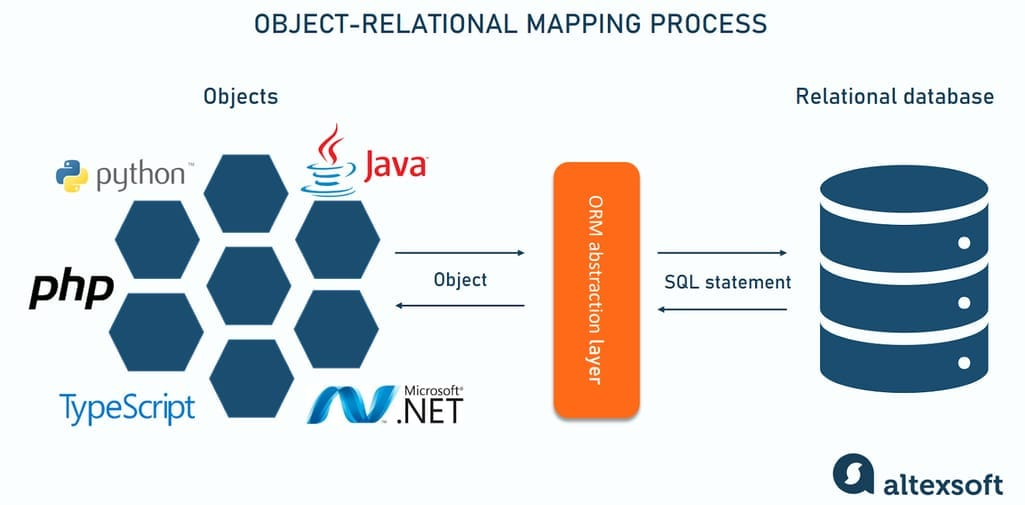  


### Key Concepts in ORM:
1. **Mapping Classes to Tables**:
   - Tables in the database are represented as Python classes.
   - Rows in the table correspond to instances of the class.
2. **Relationships**:
   - Relationships between tables (e.g., one-to-many, many-to-many) are managed using ORM.
3. **Session Management**:
   - Transactions and database queries are handled using a `Session` object.

### Example Workflow:
1. Define a class (e.g., `User`) and map it to a database table.
2. Use relationships to connect classes (e.g., `User` and `Post`).
3. Query the database using Python syntax like `session.query(User).all()`.

ORM simplifies database interactions by abstracting complex SQL queries into Python code, 
making it intuitive and reducing boilerplate.



# Exercise 1: Setting Up SQLAlchemy with MySQL

Create an SQLAlchemy engine connected to a MySQL database. Define a session and Base class.
Replace the placeholders `<username>`, `<password>`, `<host>`, and `<database>` with your actual MySQL credentials.

### Hint:
Use the `create_engine` method to connect to the database.
    


# Exercise 2: Creating Models

Define the following tables using SQLAlchemy ORM:
1. **User** with columns:
   - `id` (Integer, Primary Key)
   - `name` (String, required)
   - `email` (String, unique, required)

2. **Post** with columns:
   - `id` (Integer, Primary Key)
   - `title` (String, required)
   - `content` (String, required)
   - `user_id` (Foreign Key linking to User)

### Hint:
- Use the `relationship` function for a one-to-many relationship.
- Ensure that the `Post` table references the `User` table via a foreign key.
    


# Exercise 3: Many-to-Many Relationships

Add a `Tag` table and an association table `post_tag` to implement a many-to-many relationship between `Post` and `Tag`.

### Requirements:
- `Tag` table should have columns:
  - `id` (Integer, Primary Key)
  - `name` (String, unique, required)
- `post_tag` table should link `Post` and `Tag` tables.
- Define relationships between `Post` and `Tag`.

### Hint:
Use a `Table` object for the association table.
    


# Exercise 4: Inserting Data

Insert the following data into the tables:
1. A `User` named "John Doe" with email `john.doe@example.com`.
2. Two `Post` records for the user:
   - Title: "My First Post", Content: "This is my first post."
   - Title: "Another Post", Content: "This is another post."
3. Tags for the posts:
   - "Introduction"
   - "SQLAlchemy"

Associate the tags with the posts as follows:
- "My First Post" should have both tags.
- "Another Post" should have only the "SQLAlchemy" tag.

### Hint:
Use the `add()` and `add_all()` methods with the session object.
    


# Exercise 5: Querying Data

Write queries to:
1. Fetch all posts by the user "John Doe".
2. Fetch all tags associated with the post titled "My First Post".
3. Fetch all posts tagged with "SQLAlchemy".

### Hint:
Use the `filter()` method with `session.query`.
    


# Exercise 6: Updating Data

Update the content of the post titled "My First Post" to "This post has been updated."

### Hint:
Query the post, modify the `content` attribute, and commit the session.
    


# Exercise 7: Deleting Data

Delete the user "John Doe" and ensure that all associated posts are also deleted.

### Hint:
Use cascading delete with the `relationship` attribute.
    